# Fusion 모델 학습 (수정 버전 v2)
### Audio Scaler 사용 + 텍스트 피처 실제 사용

**수정사항:**
- ⭐ Audio Scaler 사용 (03_train_audio와 동일하게!)
- ⭐ AUDIO_EMPHASIS_CLASSES = [1, 2, 3] (클래스 1도 강조!)
- 텍스트 피처를 `tensor.pt` + `text.json`에서 실제로 로드
- 텍스트 강조점수(>=0.7)도 자동 라벨링에 반영

# config.py 안에 학습 파라미터 이거로 수정

In [ ]:
FUSION_CONFIG = {
    "weights": {'gesture': 0.4, 'audio': 0.35, 'text': 0.25},
    "threshold": 0.6,
    "min_duration": 0.3,
    "batch_size": 180,  # 여기서 바로 수정!
    "num_epochs": 100,
    "lr": 1e-4,         # 여기서 바로 수정!
    "gesture_dim": 512,
    "audio_dim": 128,
    "text_dim": 1024,
    "hidden_dim": 256,
}

In [ ]:
import os
import glob
import json
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import cv2
import librosa
from tqdm import tqdm
import warnings
import gc
import random
warnings.filterwarnings('ignore')

from config import (
    GESTURE_CONFIG, AUDIO_CONFIG, VIDEO_RAW_DIR,
    GESTURE_MODEL_PATH, AUDIO_MODEL_PATH, FUSION_MODEL_PATH, AUDIO_SCALER_PATH,
    MODEL_DIR, ensure_dirs, TEXT_TENSORS_PATH, TEXT_SCORES_PATH
) 
from utils import (
    load_gesture_model, load_audio_model, create_text_model,
    create_fusion_model
)

ensure_dirs()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: Tesla P40


## 1. Audio Feature Extractor (⭐ Scaler 사용!)

In [ ]:
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler
from config import AUDIO_CONFIG

class AudioFeatureExtractorInferenceStyle:
    """
    Inference 코드와 100% 동일한 로직을 적용한 클래스
    1. 전체 오디오 Waveform Normalize
    2. Mel-Spectrogram -> dB
    3. 전체 오디오에 대해 StandardScaler 적용 (Global Scaling)
    """
    def __init__(self, config=None):
        if config is None:
            config = AUDIO_CONFIG
        
        self.sr = config.get('sample_rate', 16000)
        self.n_mels = config.get('n_mels', 80)
        self.n_fft = config.get('n_fft', 1024)
        self.hop_length = config.get('hop_length', 512)
        self.window_size = config.get('window_size', 50)
        
        print("✅ Audio Extractor 초기화 (Inference와 동일한 Global Scaling 모드)")
    
    def process_full_audio(self, y_audio):
        """전체 오디오를 한 번에 처리하여 피처맵 생성"""
        y_audio = librosa.util.normalize(y_audio)
        
        mel = librosa.feature.melspectrogram(
            y=y_audio, sr=self.sr,
            n_mels=self.n_mels,
            n_fft=self.n_fft,
            hop_length=self.hop_length
        )
        features = librosa.power_to_db(mel, ref=np.max).T 
        
        scaler = StandardScaler()
        try:
            features_norm = scaler.fit_transform(features)
        except ValueError:
            return np.zeros((0, self.n_mels), dtype=np.float32)

        return features_norm.astype(np.float32)

try:
    audio_extractor = AudioFeatureExtractorInferenceStyle(config=AUDIO_CONFIG)
    print("✅ Audio Extractor 적용 완료")
except Exception as e:
    print(f"❌ 초기화 실패: {e}")

✅ Audio Extractor 초기화 (Inference와 동일한 Global Scaling 모드)
✅ Audio Extractor 적용 완료


## 2. 텍스트 데이터 로드 함수

In [ ]:
def load_text_data(tensor_path, json_path):
    """
    04_make_text.ipynb에서 생성한 텍스트 데이터 로드
    """
    text_tensors = []
    text_info = []
    
    if os.path.exists(tensor_path):
        tensors = torch.load(tensor_path)
        text_tensors = [t.squeeze(0) if t.dim() > 1 else t for t in tensors]
        print(f"  ✅ 텍스트 텐서 로드: {len(text_tensors)}개")
    else:
        print(f"  ⚠️ 텍스트 텐서 없음: {tensor_path}")
    
    if os.path.exists(json_path):
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        text_info = data.get('analysis', [])
        print(f"  ✅ 텍스트 정보 로드: {len(text_info)}개 문장")
    else:
        print(f"  ⚠️ 텍스트 정보 없음: {json_path}")
    
    return text_tensors, text_info


def get_text_feature_for_segment(start_sec, end_sec, text_tensors, text_info, current_video_path):
    """
    주어진 시간 구간 + 해당 비디오 파일에 맞는 텍스트 피처 반환
    """
    if not text_tensors or not text_info:
        return torch.zeros(1024)
    
    matching_tensors = []
    
    for i, info in enumerate(text_info):

        if 'video_path' in info:

            if os.path.basename(info['video_path']) != os.path.basename(current_video_path):
                continue

        sent_start = info.get('start_sec', 0)
        sent_end = info.get('end_sec', 0)
        
        if not (sent_end <= start_sec or sent_start >= end_sec):
            if i < len(text_tensors):
                matching_tensors.append(text_tensors[i])
    
    if matching_tensors:
        stacked = torch.stack(matching_tensors)
        return stacked.mean(dim=0)
    else:
        return torch.zeros(1024)

## 3. 설정 (⭐ AUDIO_EMPHASIS_CLASSES 수정!)

In [ ]:
VIDEO_RAW_DIR = "/home/stu/ai_project/영상raw" 
SEGMENT_DURATION = 1.0
OVERLAP = 0.5

GESTURE_EMPHASIS_CLASSES = [1]     
AUDIO_EMPHASIS_CLASSES = [1, 2, 3] 

batch_size = FUSION_CONFIG.get('batch_size', 32)
num_epochs = FUSION_CONFIG.get('num_epochs', 20)
lr = FUSION_CONFIG.get('lr', 1e-3)

GPU_BATCH_SIZE = 32

print(f"VIDEO_RAW_DIR: {VIDEO_RAW_DIR}")
print(f"세그먼트: {SEGMENT_DURATION}초, 겹침: {OVERLAP*100}%")
print(f"\n⭐ GESTURE_EMPHASIS_CLASSES: {GESTURE_EMPHASIS_CLASSES}")
print(f"⭐ AUDIO_EMPHASIS_CLASSES: {AUDIO_EMPHASIS_CLASSES}")

VIDEO_RAW_DIR: /home/stu/ai_project/영상raw
세그먼트: 1.0초, 겹침: 50.0%

⭐ GESTURE_EMPHASIS_CLASSES: [1]
⭐ AUDIO_EMPHASIS_CLASSES: [1, 2, 3]


## 4. 모델 로드

In [7]:
print("\n🔧 모델 로드...")

g_model = load_gesture_model(GESTURE_MODEL_PATH, device)
a_model = load_audio_model(AUDIO_MODEL_PATH, device)
t_model = create_text_model().to(device)

g_model.eval()
a_model.eval()
t_model.eval()

for m in [g_model, a_model, t_model]:
    for p in m.parameters():
        p.requires_grad = False

print("✅ 모델 로드 완료")


🔧 모델 로드...
  ✅ Gesture Model 로드 완료: /home/stu/ai_project/모델집합/gesture_model.pt
  ✅ Audio Model 로드 완료: /home/stu/ai_project/모델집합/best_bi_lstm.pth
  ℹ️ Text Model: klue/roberta-large (Dim: 1024)
✅ 모델 로드 완료


## 5. 텍스트 데이터 로드

In [8]:
print("\n📝 텍스트 데이터 로드...")
TEXT_TENSORS, TEXT_INFO = load_text_data(TEXT_TENSORS_PATH, TEXT_SCORES_PATH)

print(f"\n텍스트 텐서 개수: {len(TEXT_TENSORS)}")
print(f"텍스트 정보 개수: {len(TEXT_INFO)}")

if TEXT_INFO:
    print(f"\n첫 번째 문장 예시:")
    print(f"  - 시작: {TEXT_INFO[0].get('start_sec', 0):.2f}초")
    print(f"  - 끝: {TEXT_INFO[0].get('end_sec', 0):.2f}초")
    print(f"  - 강조점수: {TEXT_INFO[0].get('emphasis_score', 0):.2f}")


📝 텍스트 데이터 로드...
  ✅ 텍스트 텐서 로드: 3080개
  ✅ 텍스트 정보 로드: 3080개 문장

텍스트 텐서 개수: 3080
텍스트 정보 개수: 3080

첫 번째 문장 예시:
  - 시작: 0.00초
  - 끝: 3.34초
  - 강조점수: 0.55


## 6. 헬퍼 함수 정의

In [ ]:
def get_text_emphasis_score(start_sec, end_sec, current_video_path):
    """
    해당 구간 + 해당 비디오의 텍스트 강조 점수 반환 (비디오 매칭 추가!)
    """
    if not TEXT_INFO:
        return 0.0
    
    current_file_id = os.path.splitext(os.path.basename(current_video_path))[0]
    
    scores = []
    for info in TEXT_INFO:

        info_file_id = info.get('video_filename', '')
        if info_file_id != current_file_id:
            continue

        sent_start = info.get('start_sec', 0)
        sent_end = info.get('end_sec', 0)
        
        if not (sent_end <= start_sec or sent_start >= end_sec):
            scores.append(info.get('emphasis_score', 0.0))
    
    return max(scores) if scores else 0.0

## 7. 비디오 처리 함수 (⭐ Scaler 적용!)

In [ ]:
def process_video_fast(video_path, segment_duration=1.0, overlap=0.5, 
                       clip_len=16, resize_hw=(112, 112)):
    """
    비디오 처리 함수 (수정됨): 
    오디오를 전체 변환 후 슬라이싱하여 Inference 코드와 정합성 확보
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, None, []
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps if fps > 0 else 0
    
    if duration < segment_duration:
        cap.release()
        return None, None, []
    
    step = segment_duration * (1 - overlap)
    segments = []
    current = 0
    while current + segment_duration <= duration:
        segments.append((current, current + segment_duration))
        current += step
    
    if len(segments) == 0:
        cap.release()
        return None, None, []
    
    all_needed_frames = set()
    segment_frame_indices = []
    
    for start_sec, end_sec in segments:
        start_frame = int(start_sec * fps)
        end_frame = int(end_sec * fps)
        start_frame = max(0, min(start_frame, total_frames - 1))
        end_frame = max(start_frame + 1, min(end_frame, total_frames - 1))
        
        seg_len = end_frame - start_frame + 1
        if seg_len >= clip_len:
            indices = np.linspace(start_frame, end_frame, num=clip_len, dtype=int).tolist()
        else:
            base = np.linspace(start_frame, end_frame, num=seg_len, dtype=int).tolist()
            indices = (base * (clip_len // len(base) + 1))[:clip_len]
        
        segment_frame_indices.append(indices)
        all_needed_frames.update(indices)
    
    all_needed_frames = sorted(all_needed_frames)
    frame_cache = {}
    current_frame = 0
    needed_idx = 0
    
    while needed_idx < len(all_needed_frames):
        target_frame = all_needed_frames[needed_idx]
        while current_frame < target_frame:
            cap.grab()
            current_frame += 1
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, resize_hw)
            frame_cache[target_frame] = frame
        current_frame += 1
        needed_idx += 1
    
    cap.release()
    
    video_clips = []
    dummy_frame = np.zeros((resize_hw[0], resize_hw[1], 3), dtype=np.uint8)
    
    for indices in segment_frame_indices:
        frames = [frame_cache.get(i, dummy_frame) for i in indices]
        frames = np.stack(frames, axis=0).astype(np.float32) / 255.0
        frames = np.transpose(frames, (3, 0, 1, 2))
        frames = (frames - 0.5) / 0.5
        video_clips.append(torch.from_numpy(frames))
    
    audio_features_list = []
    try:
        y_full, sr = librosa.load(video_path, sr=AUDIO_CONFIG['sample_rate'])
        
        full_audio_features = audio_extractor.process_full_audio(y_full)
        
        frames_per_sec = sr / AUDIO_CONFIG['hop_length']
        window_size = AUDIO_CONFIG['window_size'] 
        
        for start_sec, end_sec in segments:
            start_frame_idx = int(start_sec * frames_per_sec)
            
            if start_frame_idx < len(full_audio_features):
                feat_seg = full_audio_features[start_frame_idx : start_frame_idx + window_size]
            else:
                feat_seg = np.zeros((0, AUDIO_CONFIG['n_mels']))

            if feat_seg.shape[0] < window_size:
                pad_len = window_size - feat_seg.shape[0]
                feat_seg = np.pad(feat_seg, ((0, pad_len), (0, 0)), mode='constant')
            
            feat_seg = feat_seg[:window_size]
            
            audio_features_list.append(torch.from_numpy(feat_seg).float())
            
    except Exception as e:
        print(f"❌ Audio processing error: {e}")
        audio_features_list = [torch.zeros(AUDIO_CONFIG['window_size'], AUDIO_CONFIG['n_mels'])] * len(segments)
    
    return video_clips, audio_features_list, segments

print("✅ 비디오 처리 함수 재정의 완료 (Audio Global Scaling 적용)")

✅ 비디오 처리 함수 재정의 완료 (Audio Global Scaling 적용)


## 8. 데이터 생성 함수

In [ ]:
@torch.no_grad()
def generate_all_data(video_raw_dir):
    """
    모든 비디오 처리하여 학습 데이터 생성
    """
    video_files = sorted(glob.glob(os.path.join(video_raw_dir, "*.mp4")))
    print(f"\n📹 비디오 수: {len(video_files)}개")
    
    all_data = []

    audio_class_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    
    for vid_idx, video_path in enumerate(video_files):
        video_name = os.path.basename(video_path)
        
        video_clips, audio_features, segments = process_video_fast(
            video_path,
            segment_duration=SEGMENT_DURATION,
            overlap=OVERLAP,
            clip_len=GESTURE_CONFIG['clip_len'],
            resize_hw=GESTURE_CONFIG['resize_hw']
        )
        
        if video_clips is None or len(video_clips) == 0:
            print(f"  [{vid_idx+1}/{len(video_files)}] {video_name}: 스킵")
            continue
        
        n_segs = len(video_clips)
        print(f"  [{vid_idx+1}/{len(video_files)}] {video_name}: {n_segs} 세그먼트", end=" ")
        
        for batch_start in range(0, n_segs, GPU_BATCH_SIZE):
            batch_end = min(batch_start + GPU_BATCH_SIZE, n_segs)
            
            batch_video = torch.stack(video_clips[batch_start:batch_end]).to(device)
            batch_audio = torch.stack(audio_features[batch_start:batch_end]).to(device)
            
            batch_text_list = []
            for j in range(batch_start, batch_end):
                start_sec, end_sec = segments[j]

                text_feat = get_text_feature_for_segment(
                    start_sec, end_sec, TEXT_TENSORS, TEXT_INFO, video_path
                )
                batch_text_list.append(text_feat)
            
            batch_text = torch.stack(batch_text_list).to(device)
            
            g_logits, g_feats = g_model(batch_video, return_feature=True)
            a_logits, a_feats = a_model(batch_audio, return_feature=True)
            _, t_feats = t_model(batch_text, return_feature=True)
            
            g_preds = torch.argmax(g_logits, dim=1).cpu().numpy()
            a_preds = torch.argmax(a_logits, dim=1).cpu().numpy()
            
            for j in range(batch_end - batch_start):
                seg_idx = batch_start + j
                g_pred = int(g_preds[j])
                a_pred = int(a_preds[j])
                start_sec, end_sec = segments[seg_idx]
                
                audio_class_counts[a_pred] = audio_class_counts.get(a_pred, 0) + 1
                
                text_emphasis = get_text_emphasis_score(start_sec, end_sec, video_path)
                
                vote_score = 0

                if g_pred in GESTURE_EMPHASIS_CLASSES:
                    vote_score += 1

                if a_pred in AUDIO_EMPHASIS_CLASSES:
                    vote_score += 1

                if text_emphasis >= 0.8:
                    vote_score += 1

                auto_label = 1 if vote_score >= 2 else 0
                
                all_data.append({
                    'gesture_feat': g_feats[j].cpu(),
                    'audio_feat': a_feats[j].cpu(),
                    'text_feat': t_feats[j].cpu(),
                    'gesture_pred': g_pred,
                    'audio_pred': a_pred,
                    'text_emphasis': text_emphasis,
                    'auto_label': auto_label,
                    'video_path': video_path,
                    'start_sec': start_sec,
                    'end_sec': end_sec,
                })
            
        
        print("✓")
        
        del video_clips, audio_features
        gc.collect()
        torch.cuda.empty_cache()

    print(f"\n📊 Audio 클래스 분포: {audio_class_counts}")
    
    return all_data


print("✅ 데이터 생성 함수 정의 완료")

✅ 데이터 생성 함수 정의 완료


## 9. 데이터 생성 또는 로드

⚠️ **중요**: 이전에 생성한 `auto_labeled_data_with_text.pt`가 있으면 삭제하고 새로 생성해야 합니다!

In [ ]:
SAVE_PATH = os.path.join(MODEL_DIR, "auto_labeled_data_with_text_minseong.pt")

if os.path.exists(SAVE_PATH):
    print(f"🗑️ 기존 파일 삭제 중: {SAVE_PATH}")
    os.remove(SAVE_PATH)

print("\n🚀 데이터 생성 시작...")
all_data = generate_all_data(VIDEO_RAW_DIR)

print(f"\n💾 데이터 저장 중... ({SAVE_PATH})")
torch.save(all_data, SAVE_PATH)
print("✅ 저장 완료!")


🚀 데이터 생성 시작...

📹 비디오 수: 62개
  [1/62] 1.mp4: 686 세그먼트 ✓
  [2/62] 10.mp4: 556 세그먼트 ✓
  [3/62] 11.mp4: 701 세그먼트 ✓
  [4/62] 12.mp4: 690 세그먼트 ✓
  [5/62] 13.mp4: 659 세그먼트 ✓
  [6/62] 14.mp4: 740 세그먼트 ✓
  [7/62] 15.mp4: 674 세그먼트 ✓
  [8/62] 16.mp4: 644 세그먼트 ✓
  [9/62] 17.mp4: 668 세그먼트 ✓
  [10/62] 18.mp4: 785 세그먼트 ✓
  [11/62] 19.mp4: 840 세그먼트 ✓
  [12/62] 2.mp4: 660 세그먼트 ✓
  [13/62] 20.mp4: 695 세그먼트 ✓
  [14/62] 20251211_210610_완.mp4: 206 세그먼트 ✓
  [15/62] 20251211_220230_완.mp4: 264 세그먼트 ✓
  [16/62] 20251211_220505_완.mp4: 228 세그먼트 ✓
  [17/62] 20251211_221003_완.mp4: 243 세그먼트 ✓
  [18/62] 20251211_221258_완.mp4: 200 세그먼트 ✓
  [19/62] 20251211_221448_완.mp4: 202 세그먼트 ✓
  [20/62] 20251211_221704_완.mp4: 239 세그먼트 ✓
  [21/62] 20251211_221944_완.mp4: 215 세그먼트 ✓
  [22/62] 20251211_222459_완.mp4: 248 세그먼트 ✓
  [23/62] 20251212_003918.mp4: 205 세그먼트 ✓
  [24/62] 20251212_162705.mp4: 233 세그먼트 ✓
  [25/62] 20251212_163047.mp4: 204 세그먼트 ✓
  [26/62] 20251212_163243.mp4: 200 세그먼트 ✓
  [27/62] 20251212_163439.mp4: 196 세그먼트 

In [ ]:
print(f"\n{'='*50}")
print(f"📊 총 세그먼트: {len(all_data)}")

labels = [d['auto_label'] for d in all_data]
num_pos = sum(labels)
num_neg = len(labels) - num_pos
print(f"📊 강조(1): {num_pos}, 비강조(0): {num_neg}")

g_preds = [d['gesture_pred'] for d in all_data]
a_preds = [d['audio_pred'] for d in all_data]
print(f"📊 Gesture: {dict(zip(*np.unique(g_preds, return_counts=True)))}")
print(f"📊 Audio: {dict(zip(*np.unique(a_preds, return_counts=True)))}")

text_emph = [d.get('text_emphasis', 0) for d in all_data]
high_text = sum(1 for t in text_emph if t >= 0.8)
print(f"📊 Text (>=0.8): {high_text}개")

print(f"\n📊 Audio 클래스별 분포:")
print(f"   - 클래스 0 (Normal/비강조): {a_preds.count(0)}개")
print(f"   - 클래스 1 (Pause_Talk/강조): {a_preds.count(1)}개")
print(f"   - 클래스 2 (High_Tone/강조): {a_preds.count(2)}개")
print(f"   - 클래스 3 (Loud/강조): {a_preds.count(3)}개")


📊 총 세그먼트: 31716
📊 강조(1): 6046, 비강조(0): 25670
📊 Gesture: {0: 25187, 1: 6529}
📊 Audio: {0: 24385, 1: 1860, 2: 2963, 3: 2508}
📊 Text (>=0.8): 13184개

📊 Audio 클래스별 분포:
   - 클래스 0 (Normal/비강조): 24385개
   - 클래스 1 (Pause_Talk/강조): 1860개
   - 클래스 2 (High_Tone/강조): 2963개
   - 클래스 3 (Loud/강조): 2508개


## 10. Dataset & DataLoader

In [ ]:
class FusionDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        d = self.data[idx]
        return (
            d['gesture_feat'], 
            d['audio_feat'], 
            d['text_feat'], 
            torch.tensor(d['auto_label'], dtype=torch.float)
        )


random.seed(42)

video_groups = {}
for item in all_data:
    vp = item['video_path']
    if vp not in video_groups:
        video_groups[vp] = []
    video_groups[vp].append(item)

videos = list(video_groups.keys())
random.shuffle(videos)
split_idx = int(len(videos) * 0.8)
train_videos = set(videos[:split_idx])

train_data = [item for v, items in video_groups.items() if v in train_videos for item in items]
val_data = [item for v, items in video_groups.items() if v not in train_videos for item in items]

print(f"📊 Train: {len(train_data)}, Val: {len(val_data)}")

train_labels = [d['auto_label'] for d in train_data]
n_neg, n_pos = train_labels.count(0), train_labels.count(1)
pos_weight = torch.tensor([n_neg/n_pos if n_pos > 0 else 1.0]).to(device)
print(f"📊 Pos weight: {pos_weight.item():.2f}")

train_loader = DataLoader(FusionDataset(train_data), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(FusionDataset(val_data), batch_size=batch_size, shuffle=False)
print(f"📊 Batches - Train: {len(train_loader)}, Val: {len(val_loader)}")

📊 Train: 24484, Val: 7232
📊 Pos weight: 4.37
📊 Batches - Train: 137, Val: 41


## 11. Fusion 모델 생성

In [ ]:
import torch
import torch.nn as nn

class FusionMLP(nn.Module):
    def __init__(self, gesture_dim, audio_dim, text_dim, hidden_dim, num_classes, use_text=True, dropout=0.3):
        super(FusionMLP, self).__init__()
        
        input_dim = gesture_dim + audio_dim
        if use_text:
            input_dim += text_dim
            
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(p=dropout),  
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(p=dropout), 
            
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, gesture, audio, text=None):
        if text is not None:
            x = torch.cat([gesture, audio, text], dim=1)
        else:
            x = torch.cat([gesture, audio], dim=1)
        return self.net(x)


def create_fusion_model(gesture_dim, audio_dim, text_dim, hidden_dim, num_classes, use_text=True, dropout=0.3):
    return FusionMLP(gesture_dim, audio_dim, text_dim, hidden_dim, num_classes, use_text, dropout)

print("✅ 모델 클래스 재정의 완료 (Dropout 조절 가능)")

✅ 모델 클래스 재정의 완료 (Dropout 조절 가능)


In [ ]:
f_model = create_fusion_model(
    gesture_dim=FUSION_CONFIG['gesture_dim'],
    audio_dim=FUSION_CONFIG['audio_dim'],
    text_dim=FUSION_CONFIG['text_dim'],
    hidden_dim=FUSION_CONFIG['hidden_dim'],
    num_classes=1,
    use_text=True,
    dropout=0.5  
).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(f_model.parameters(), lr=FUSION_CONFIG['lr'], weight_decay=1e-3)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

print(f"📊 파라미터 개수: {sum(p.numel() for p in f_model.parameters()):,}")
print(f_model)

📊 파라미터 개수: 460,033
FusionMLP(
  (net): Sequential(
    (0): Linear(in_features=1664, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=128, out_features=1, bias=True)
  )
)


## 12. 학습

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_metrics(y_true, y_pred):
    """
    정답(y_true)과 예측(y_pred)을 받아 Acc, Precision, Recall, F1(Macro)을 반환
    """

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    acc = accuracy_score(y_true, y_pred)
    
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    
    return acc, precision, recall, f1

history = {
    'train_loss': [], 'val_loss': [], 
    'train_acc': [], 'val_acc': [],
    'val_f1': [], 'val_precision': [], 'val_recall': []
}

best_val_f1 = 0.0  
patience_counter = 0
patience = 10

print(f"\n🚀 학습 시작! (epochs={num_epochs})")
print("=" * 90)

for epoch in range(num_epochs):
    f_model.train()
    train_loss = 0
    train_preds = []
    train_targets = []
    
    for g_feat, a_feat, t_feat, labels in train_loader:
        g_feat = g_feat.to(device)
        a_feat = a_feat.to(device)
        t_feat = t_feat.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = f_model(g_feat, a_feat, t_feat).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        preds = (torch.sigmoid(outputs) >= 0.5).float()
        train_preds.extend(preds.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())
    
    train_loss /= len(train_loader)
    train_acc, train_prec, train_rec, train_f1 = calculate_metrics(train_targets, train_preds)
    
    f_model.eval()
    val_loss = 0
    val_preds = []
    val_targets = []
    
    with torch.no_grad():
        for g_feat, a_feat, t_feat, labels in val_loader:
            g_feat = g_feat.to(device)
            a_feat = a_feat.to(device)
            t_feat = t_feat.to(device)
            labels = labels.to(device)
            
            outputs = f_model(g_feat, a_feat, t_feat).squeeze()
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()

            preds = (torch.sigmoid(outputs) >= 0.5).float()
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_acc, val_prec, val_rec, val_f1 = calculate_metrics(val_targets, val_preds)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    print(f"Epoch [{epoch+1:03d}/{num_epochs}] "
          f"Loss: {train_loss:.4f}/{val_loss:.4f} | "
          f"Acc: {train_acc*100:.1f}%/{val_acc*100:.1f}% | "
          f"F1(Macro): {val_f1:.4f} | Pre: {val_prec:.4f} | Rec: {val_rec:.4f}", end="")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(f_model.state_dict(), FUSION_MODEL_PATH)
        print(f" ✅ Best F1!")
    else:
        patience_counter += 1
        print()
        if patience_counter >= patience:
            print(f"\n🛑 Early stopping at epoch {epoch+1}")
            break

print("=" * 90)
print(f"\n✅ 학습 완료! Best Val F1: {best_val_f1:.4f}")
print(f"모델 저장: {FUSION_MODEL_PATH}")


🚀 학습 시작! (epochs=100)
Epoch [001/100] Loss: 0.6019/0.6923 | Acc: 84.6%/83.3% | F1(Macro): 0.7830 | Pre: 0.7594 | Rec: 0.8438 ✅ Best F1!
Epoch [002/100] Loss: 0.5644/0.6993 | Acc: 83.4%/83.7% | F1(Macro): 0.7869 | Pre: 0.7629 | Rec: 0.8452 ✅ Best F1!
Epoch [003/100] Loss: 0.5505/0.7282 | Acc: 83.3%/84.8% | F1(Macro): 0.7944 | Pre: 0.7711 | Rec: 0.8396 ✅ Best F1!
Epoch [004/100] Loss: 0.5588/0.7147 | Acc: 83.4%/84.3% | F1(Macro): 0.7912 | Pre: 0.7673 | Rec: 0.8416
Epoch [005/100] Loss: 0.5677/0.6767 | Acc: 83.5%/77.3% | F1(Macro): 0.7344 | Pre: 0.7287 | Rec: 0.8401
Epoch [006/100] Loss: 0.5571/0.8151 | Acc: 83.1%/85.5% | F1(Macro): 0.7931 | Pre: 0.7766 | Rec: 0.8167
Epoch [007/100] Loss: 0.6099/0.6903 | Acc: 83.5%/77.8% | F1(Macro): 0.7375 | Pre: 0.7290 | Rec: 0.8376
Epoch [008/100] Loss: 0.5923/0.6534 | Acc: 83.0%/80.7% | F1(Macro): 0.7632 | Pre: 0.7450 | Rec: 0.8476
Epoch [009/100] Loss: 0.5621/0.6507 | Acc: 82.8%/82.0% | F1(Macro): 0.7745 | Pre: 0.7531 | Rec: 0.8517
Epoch [010/100] L

## 13. 학습 결과 시각화

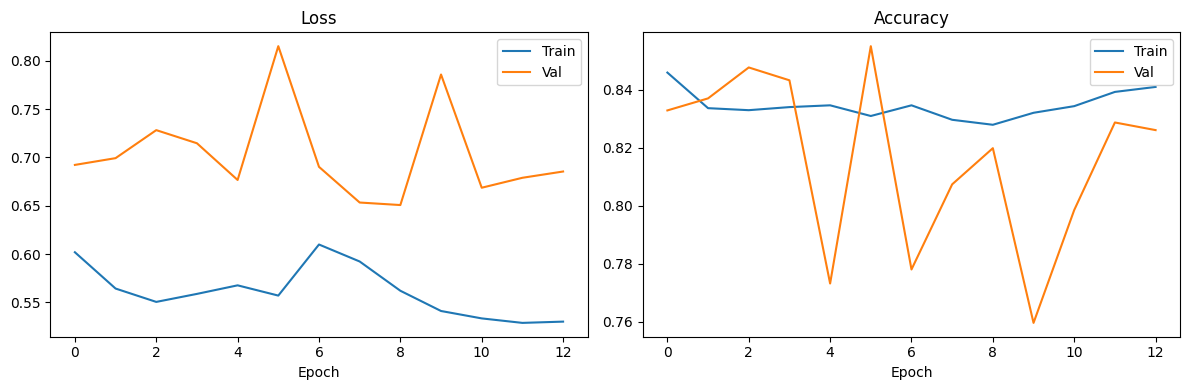


📊 그래프 저장: /home/stu/ai_project/모델집합/fusion_curves.png


In [33]:
with open(os.path.join(MODEL_DIR, "fusion_history.json"), 'w') as f:
    json.dump(history, f)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(history['train_loss'], label='Train')
ax[0].plot(history['val_loss'], label='Val')
ax[0].legend()
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')

ax[1].plot(history['train_acc'], label='Train')
ax[1].plot(history['val_acc'], label='Val')
ax[1].legend()
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'fusion_curves.png'))
plt.show()

print(f"\n📊 그래프 저장: {os.path.join(MODEL_DIR, 'fusion_curves.png')}")

## 완료!

### 수정사항 (v2):
1. ✅ **Audio Scaler 사용** - `audio_scaler.pkl` 로드해서 적용
2. ✅ **AUDIO_EMPHASIS_CLASSES = [1, 2, 3]** - 클래스 1도 강조로 인식
3. ✅ 텍스트 피처를 `tensor.pt`에서 실제로 로드
4. ✅ 텍스트 강조점수(>=0.7)도 자동 라벨링에 반영

### 생성된 파일:
- `모델집합/fusion_model.pt`
- `모델집합/auto_labeled_data_with_text_v2.pt` (새 버전)
- `모델집합/fusion_history.json`
- `모델집합/fusion_curves.png`